In [2]:
import os
import sys 
sys.path.append(os.path.abspath('..'))
from pathlib import Path
from utils import create_directory
from model import test

from tdr import *

In [5]:
data_dir = create_directory(directory_name='modular2') # loss0_if # modular
modular = 1
model_num = 7
# pert - input fix [0,11,13]
# loss0_if - [2,3,7,13] 
model_name = "model{:02d}".format(model_num)

data = []
phases = ['NF1','FF1']
ff = [0,8]
batches = [1000,16000]

for i,p in enumerate(phases):
    weight_file = list(Path(data_dir).glob(f'{model_name}_phase={p}_*_batch={batches[i]}_weights'))[0]
    cfg_file = list(Path(data_dir).glob(f'{model_name}_phase={p}_*_cfg.json'))[0]
    data.append(test(cfg_file,weight_file,ff_coefficient=ff[i],calc_endpoint_force=True,modular=modular))

RuntimeError: Error(s) in loading state_dict for ModularPolicyGRU:
	Missing key(s) in state_dict: "Wz", "bz", "Wr", "br", "Wh", "bh", "Y", "bY", "mask_Wz", "mask_Wr", "mask_Wh", "mask_Y", "mask_bz", "mask_br", "mask_bh", "mask_bY". 
	Unexpected key(s) in state_dict: "gru.weight_ih_l0", "gru.weight_hh_l0", "gru.bias_ih_l0", "gru.bias_hh_l0", "fc.weight", "fc.bias". 
	size mismatch for h0: copying a param with shape torch.Size([1, 1, 128]) from checkpoint, the shape in current model is torch.Size([1, 656]).

In [1]:
#module_sizes = [128, 128, 128, 32]

#index_neuron = np.arange(0,module_sizes[0]) # PMd
#index_neuron = np.arange(module_sizes[0],module_sizes[0]+module_sizes[1]) # M1
#index_neuron = np.arange(module_sizes[0]+module_sizes[1],module_sizes[0]+module_sizes[1]+module_sizes[2]) # S1
#index_neuron = np.arange(module_sizes[0]+module_sizes[1]+module_sizes[2],module_sizes[0]+module_sizes[1]+module_sizes[2]+module_sizes[3]) # Spinal




# PFC, PMd, M1, S1, PPC, Spinal
module_sizes = [128, 128, 128, 128, 128, 16]
index_neuron = np.arange(0,module_sizes[0]) # PFC
index_neuron = np.arange(module_sizes[0],module_sizes[0]+module_sizes[1]) # PMd
index_neuron = np.arange(module_sizes[0]+module_sizes[1],module_sizes[0]+module_sizes[1]+module_sizes[2]) # M1
index_neuron = np.arange(module_sizes[0]+module_sizes[1]+module_sizes[2],module_sizes[0]+module_sizes[1]+module_sizes[2]+module_sizes[3]) # S1
index_neuron = np.arange(module_sizes[0]+module_sizes[1]+module_sizes[2]+module_sizes[3],module_sizes[0]+module_sizes[1]+module_sizes[2]+module_sizes[3]+module_sizes[4]) # PPC
index_neuron = np.arange(module_sizes[0]+module_sizes[1]+module_sizes[2]+module_sizes[3]+module_sizes[4],module_sizes[0]+module_sizes[1]+module_sizes[2]+module_sizes[3]+module_sizes[4]+module_sizes[5]) # Spinal



NameError: name 'np' is not defined

In [69]:
# RUN TDR
Data_prep = get_data(data,phases,go_cue_idx=18,force_idx=25,index_neuron=index_neuron)

beforeLearningN = Data_prep['Y'][0]
afterLearningN = Data_prep['Y'][1]

# Combine beforeLearningN and afterLearningN
combined_N = np.vstack((beforeLearningN, afterLearningN))

# Calculate the mean along axis 0 (mean of each neuron across conditions)
mean_N = np.mean(combined_N, axis=0)


# Center beforeLearningN and afterLearningN
beforeLearningN_center = beforeLearningN - mean_N
afterLearningN_center = afterLearningN - mean_N

before_learning_X = Data_prep['X'][0]
after_learning_X = Data_prep['X'][1]


betaNeural2Behav, betaNeural2BehavOrth, projectedStates = build_TDR_subspace(before_learning_X,beforeLearningN_center,
                                                                             after_learning_N=afterLearningN_center,
                                                                             after_learning_X=after_learning_X,
                                                                             TDR_options=1)

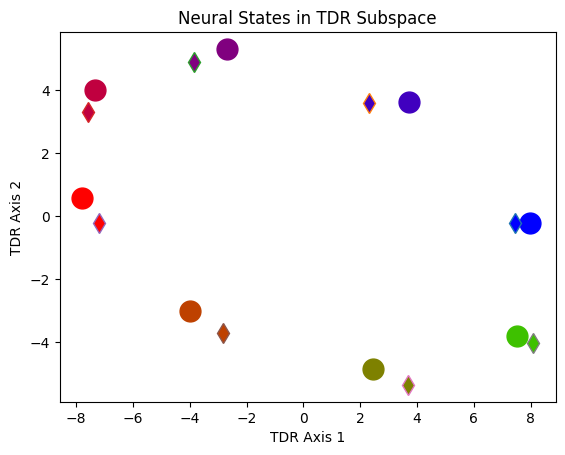

In [70]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming projectedStates is your (8,2) matrix
n_cond = int(projectedStates.shape[0] / 2)


angle_set = np.deg2rad(np.arange(0, 360, 45))  # 8 directions
#angle_set = np.deg2rad(np.array([0,45,60,75,90,105,120,135,180,225,315]))
color_list = [plt.cm.brg(cond / (2 * np.pi)) for cond in angle_set]

# Create a scatter plot
plt.figure()
for i in range(n_cond):
    plt.plot(projectedStates[i, 0], projectedStates[i, 1], '.', markersize=30, color=color_list[i])
    plt.plot(projectedStates[i + n_cond, 0], projectedStates[i + n_cond, 1], 'd', markersize=10, markerfacecolor=color_list[i])

plt.xlabel('TDR Axis 1')
plt.ylabel('TDR Axis 2')
plt.title('Neural States in TDR Subspace')

plt.show()

In [38]:
# Assuming beforeLearningN_center and afterLearningN_center are your (C, N) matrices
# where C is the number of conditions, and N is the number of neurons

# Define the uniform-shift learning axis
uniformAxis = np.mean(afterLearningN_center, axis=0) - np.mean(beforeLearningN_center, axis=0)
uniformAxis = uniformAxis.reshape(-1, 1)

# Orthogonalize the uniform shift against the TDR axes
uniformAxisOrth = uniformAxis - np.dot(betaNeural2BehavOrth[:, 0], uniformAxis) / np.linalg.norm(betaNeural2BehavOrth[:, 0]) ** 2 * betaNeural2BehavOrth[:, 0][:,None]
uniformAxisOrth = uniformAxisOrth - np.dot(betaNeural2BehavOrth[:, 1], uniformAxisOrth) / np.linalg.norm(betaNeural2BehavOrth[:, 1]) ** 2 * betaNeural2BehavOrth[:, 1][:,None]

# Normalize the uniform shift axis
uniformAxisOrthNorm = uniformAxisOrth / np.linalg.norm(uniformAxisOrth)

# Project neural activity onto the uniform-shift axis
uniformStates = np.vstack((beforeLearningN_center, afterLearningN_center)) @ uniformAxisOrthNorm
uniformStates

array([[-0.08675979],
       [-0.08222724],
       [-0.07756741],
       [-0.07915243],
       [-0.08339262],
       [-0.08475069],
       [-0.08304053],
       [-0.08428255],
       [ 0.07515138],
       [ 0.07768385],
       [ 0.08401206],
       [ 0.08653803],
       [ 0.08533846],
       [ 0.0845009 ],
       [ 0.08592016],
       [ 0.08202806]])